In [1]:
import pickle
import os.path
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import torch
from torch import nn
from torch.optim import SGD
from torch.nn import functional as F
from matplotlib import pyplot as plt
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
with open('/Users/jamoth/DSR/DataScienceJobs/Pickles/word2vec.pkl', 'rb') as file:
    w2v_model = pickle.load(file)
    
with open('/Users/jamoth/DSR/DataScienceJobs/data/W2V.pkl', 'rb') as file:
    X_train, X_val, X_test = pickle.load(file)

with open('/Users/jamoth/DSR/DataScienceJobs/data/yTrainValTest.pkl', 'rb') as file:
    y_train, y_val, y_test = pickle.load(file) 

In [3]:
train_label = torch.Tensor(y_train)
train_data = torch.Tensor(X_train)

In [17]:
X_train[0].reshape(-1)

array([[ 0.03215016, -0.02438095, -0.04037474, ..., -0.07282206,
        -0.00495473,  0.01345142],
       [ 0.0583657 ,  0.00238091, -0.03787627, ..., -0.03866876,
         0.03635242, -0.02382568],
       [-0.03486216,  0.01813217, -0.00027153, ...,  0.01979053,
         0.00540992, -0.04960964],
       ...,
       [-0.00379949, -0.05085203, -0.01457347, ...,  0.03863429,
        -0.05376931, -0.01451856],
       [ 0.02922212, -0.06386179,  0.0518636 , ..., -0.02635334,
         0.06598441,  0.0387895 ],
       [ 0.05430917,  0.00225234, -0.00578877, ..., -0.14030145,
         0.00345045,  0.07174925]])

In [3]:

class Perceptron(nn.Module):
    def __init__(self, n_in, n_hi):
        super(Perceptron, self).__init__()
        self.fc1 = nn.Linear(n_in, n_hi, bias=True) #n_in: number of input, n_hi(100): number of output
        self.fc2 = nn.Linear(n_hi, 1, bias=True)   # add hidden layer, n_hi(100): number of input, 1
        
    'perceptron() == perceptron.forward()'                 
    def forward(self, x):      # 
        x = self.fc1(x)        # apply first layer to X
        x = F.relu(x)          # apply an activation function
        x = self.fc2(x)        # apply second layer to X
        return x

In [4]:
#perceptron = Perceptron(X_train.shape, 1000)
#optimizer = SGD(perceptron.parameters(), lr=0.01)

In [15]:
N_EPOCHS = 5
# init the model, loss and optimizer
net = Perceptron(X_train.shape[1]*X_train.shape[2], 300)
#net.apply(custom_weights)  # applies the custom_weights function: setting weights to zero
optimizer = SGD(net.parameters(), lr=0.05)
criterion = nn.SmoothL1Loss()
net = net.to(DEVICE)


loss_history = []
for epoch in range(N_EPOCHS):
    print("training epoch {}".format(epoch))
    for xsample, ysample in zip(X_train, y_train):
        optimizer.zero_grad() 
        # zero the gradients
        # batch preparation

        xsample = xsample.reshape(-1)
        x = torch.Tensor(xsample).unsqueeze(0) # tensor([[0.8745, 0.5205]]) torch.Size([1, 2])
        y = torch.Tensor([ysample]).unsqueeze(0) # tensor([[1.]]) torch.Size([1, 1])
        x = x.to(DEVICE)    # transfers the x to GPU(if available, otherwise CPU -> see Code above)
        y = y.to(DEVICE)

        # forward pass
        out = net(x) # prediction, y_hat, 

        # loss calculation
        loss = criterion(out, y)

        # calculating gradients
        loss.backward()

        # changing the weights by specified(in the optimizer init) learning rate
        optimizer.step()

        #append calculated loss to the history
        loss  = loss.detach().cpu().numpy()
        loss_history.append(loss)


print("input shape (BS, n_classes):", x.shape)
print("target shape (BS, 1):", y.shape)
print("output shape", out.shape)

training epoch 0
training epoch 1
training epoch 2
training epoch 3
training epoch 4
input shape (BS, n_classes): torch.Size([1, 27600])
target shape (BS, 1): torch.Size([1, 1])
output shape torch.Size([1, 1])


Text(0, 0.5, 'loss (CE)')

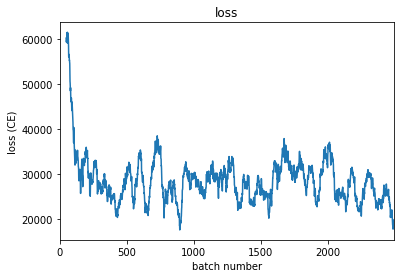

In [16]:
history = pd.DataFrame(loss_history, columns=['loss'])
history.loss[:2500].rolling(50).mean().plot()
plt.title("loss")
plt.xlabel("batch number")
plt.ylabel("loss (CE)")

In [17]:
history.loss

0         67499.484375
1        124999.382812
2         37499.277344
3         33059.289062
4         36010.683594
             ...      
18910     39559.570312
18911     27386.294922
18912      6060.531250
18913       285.085938
18914     12391.749023
Name: loss, Length: 18915, dtype: float32